In [10]:
# @title 1. Setup: Install Libraries and Mount Google Drive
# @markdown Run this cell first to install necessary libraries and mount Google Drive for model saving.
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import warnings

# Suppress warnings for cleaner output (optional)
warnings.filterwarnings('ignore')

# Install Streamlit and pyngrok for public access
!pip install -q streamlit pyngrok

# Mount Google Drive (necessary to save the trained model)
from google.colab import drive
drive.mount('/content/drive')

print("Setup complete: Libraries installed and Google Drive mounted.")

# --- Global Configuration ---
# Centralize configuration parameters
CONFIG = {
    "latent_dim": 100,  # Size of the noise vector
    "num_classes": 10,  # Digits 0-9
    "img_size": 28,
    "channels": 1,
    "epochs": 10, # You can adjust this. 150-200 epochs usually gives decent results.
    "batch_size": 64,
    "lr": 0.0002,
    "beta1": 0.5, # For Adam optimizer
    "save_model_dir_drive": '/content/drive/MyDrive/mnist_cgan_models', # Path in Google Drive
    "generator_model_filename": 'generator_mnist_cgan.pth',
    "discriminator_model_filename": 'discriminator_mnist_cgan.pth'
}


# Create directory to save models in Google Drive
os.makedirs(CONFIG["save_model_dir_drive"], exist_ok=True)
generator_path_drive = os.path.join(CONFIG["save_model_dir_drive"], CONFIG["generator_model_filename"])
discriminator_path_drive = os.path.join(CONFIG["save_model_dir_drive"], CONFIG["discriminator_model_filename"])

print(f"Models will be saved to: {CONFIG['save_model_dir_drive']}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete: Libraries installed and Google Drive mounted.
Models will be saved to: /content/drive/MyDrive/mnist_cgan_models


In [4]:
# @title 2. Model Definition (Generator and Discriminator)
# @markdown This cell defines the PyTorch Conditional GAN architecture.

# --- Model Architecture (Conditional GAN) ---

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.channels = channels

        # Embedding for class labels
        self.label_emb = nn.Embedding(num_classes, num_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + num_classes, 128),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, self.img_size * self.img_size * self.channels),
            nn.Tanh() # Output pixels in [-1, 1] range
        )

    def forward(self, noise, labels):
        # Concatenate noise vector with one-hot encoded labels
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.channels, self.img_size, self.img_size)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.channels = channels

        # Embedding for class labels
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size * self.channels + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output probability [0, 1]
        )

    def forward(self, img, labels):
        # Flatten image
        img_flat = img.view(img.size(0), -1)
        # Concatenate flattened image with one-hot encoded labels
        d_input = torch.cat((img_flat, self.label_emb(labels)), -1)
        validity = self.model(d_input)
        return validity

print("Generator and Discriminator models defined.")

Generator and Discriminator models defined.


MNIST dataset loaded with 60000 samples.
Models, loss function, and optimizers initialized.
Training for 10 epochs...


Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6310 | G loss: 0.9355
  Batch 200/938 | D loss: 0.6936 | G loss: 0.7463
  Batch 300/938 | D loss: 0.6478 | G loss: 0.8822
  Batch 400/938 | D loss: 0.6674 | G loss: 0.7951
  Batch 500/938 | D loss: 0.7046 | G loss: 0.7667
  Batch 600/938 | D loss: 0.6362 | G loss: 0.8626
  Batch 700/938 | D loss: 0.5990 | G loss: 0.9561
  Batch 800/938 | D loss: 0.6151 | G loss: 0.8092
  Batch 900/938 | D loss: 0.6833 | G loss: 1.1588
Epoch 1 completed. D loss: 0.6323, G loss: 0.9990


Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6210 | G loss: 0.7393
  Batch 200/938 | D loss: 0.6093 | G loss: 0.9508
  Batch 300/938 | D loss: 0.6127 | G loss: 1.1241
  Batch 400/938 | D loss: 0.6360 | G loss: 0.8565
  Batch 500/938 | D loss: 0.5849 | G loss: 1.1698
  Batch 600/938 | D loss: 0.5798 | G loss: 0.7256
  Batch 700/938 | D loss: 0.6380 | G loss: 0.9755
  Batch 800/938 | D loss: 0.6040 | G loss: 1.1689
  Batch 900/938 | D loss: 0.6042 | G loss: 0.8251
Epoch 2 completed. D loss: 0.5800, G loss: 1.0773


Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6453 | G loss: 1.0481
  Batch 200/938 | D loss: 0.6071 | G loss: 0.9703
  Batch 300/938 | D loss: 0.5936 | G loss: 0.8827
  Batch 400/938 | D loss: 0.5896 | G loss: 1.0479
  Batch 500/938 | D loss: 0.5593 | G loss: 0.9520
  Batch 600/938 | D loss: 0.6048 | G loss: 0.6145
  Batch 700/938 | D loss: 0.7035 | G loss: 1.2182
  Batch 800/938 | D loss: 0.6132 | G loss: 1.2942
  Batch 900/938 | D loss: 0.5654 | G loss: 0.9902
Epoch 3 completed. D loss: 0.6012, G loss: 1.3730


Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6218 | G loss: 0.9147
  Batch 200/938 | D loss: 0.5967 | G loss: 1.0194
  Batch 300/938 | D loss: 0.5851 | G loss: 0.8982
  Batch 400/938 | D loss: 0.6110 | G loss: 1.1724
  Batch 500/938 | D loss: 0.6308 | G loss: 0.9545
  Batch 600/938 | D loss: 0.5935 | G loss: 0.9365
  Batch 700/938 | D loss: 0.5950 | G loss: 0.9524
  Batch 800/938 | D loss: 0.6697 | G loss: 0.9304
  Batch 900/938 | D loss: 0.6084 | G loss: 0.7072
Epoch 4 completed. D loss: 0.6606, G loss: 0.9550


Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.5523 | G loss: 1.0190
  Batch 200/938 | D loss: 0.6545 | G loss: 0.9321
  Batch 300/938 | D loss: 0.6384 | G loss: 0.9266
  Batch 400/938 | D loss: 0.6768 | G loss: 0.9248
  Batch 500/938 | D loss: 0.6406 | G loss: 0.8683
  Batch 600/938 | D loss: 0.6718 | G loss: 0.8942
  Batch 700/938 | D loss: 0.6039 | G loss: 0.9291
  Batch 800/938 | D loss: 0.6127 | G loss: 0.8139
  Batch 900/938 | D loss: 0.6797 | G loss: 0.9516
Epoch 5 completed. D loss: 0.6217, G loss: 0.6390


Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6327 | G loss: 0.7442
  Batch 200/938 | D loss: 0.6619 | G loss: 0.8995
  Batch 300/938 | D loss: 0.6494 | G loss: 0.8566
  Batch 400/938 | D loss: 0.6006 | G loss: 1.1765
  Batch 500/938 | D loss: 0.5814 | G loss: 0.9155
  Batch 600/938 | D loss: 0.6387 | G loss: 0.9233
  Batch 700/938 | D loss: 0.6599 | G loss: 0.8843
  Batch 800/938 | D loss: 0.6468 | G loss: 0.9346
  Batch 900/938 | D loss: 0.6745 | G loss: 0.8836
Epoch 6 completed. D loss: 0.6153, G loss: 0.7013


Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6674 | G loss: 0.7647
  Batch 200/938 | D loss: 0.6676 | G loss: 0.8252
  Batch 300/938 | D loss: 0.6939 | G loss: 0.9019
  Batch 400/938 | D loss: 0.6163 | G loss: 0.8605
  Batch 500/938 | D loss: 0.6661 | G loss: 0.8263
  Batch 600/938 | D loss: 0.6764 | G loss: 0.7875
  Batch 700/938 | D loss: 0.6754 | G loss: 0.7583
  Batch 800/938 | D loss: 0.6871 | G loss: 0.8459
  Batch 900/938 | D loss: 0.6425 | G loss: 0.9868
Epoch 7 completed. D loss: 0.6497, G loss: 0.8333


Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6723 | G loss: 0.7801
  Batch 200/938 | D loss: 0.6729 | G loss: 0.9293
  Batch 300/938 | D loss: 0.6758 | G loss: 0.8292
  Batch 400/938 | D loss: 0.6149 | G loss: 0.7658
  Batch 500/938 | D loss: 0.6627 | G loss: 0.8102
  Batch 600/938 | D loss: 0.6131 | G loss: 0.8241
  Batch 700/938 | D loss: 0.6242 | G loss: 0.8303
  Batch 800/938 | D loss: 0.7009 | G loss: 0.8690
  Batch 900/938 | D loss: 0.6463 | G loss: 0.7518
Epoch 8 completed. D loss: 0.6366, G loss: 0.8333


Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6775 | G loss: 0.7895
  Batch 200/938 | D loss: 0.6908 | G loss: 0.8690
  Batch 300/938 | D loss: 0.6889 | G loss: 0.7375
  Batch 400/938 | D loss: 0.6346 | G loss: 0.8141
  Batch 500/938 | D loss: 0.6445 | G loss: 0.7778
  Batch 600/938 | D loss: 0.6678 | G loss: 0.8227
  Batch 700/938 | D loss: 0.7158 | G loss: 0.8646
  Batch 800/938 | D loss: 0.6811 | G loss: 0.7585
  Batch 900/938 | D loss: 0.6590 | G loss: 0.7816
Epoch 9 completed. D loss: 0.6502, G loss: 0.6375


Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

  Batch 100/938 | D loss: 0.6987 | G loss: 0.7545
  Batch 200/938 | D loss: 0.6680 | G loss: 0.8993
  Batch 300/938 | D loss: 0.6650 | G loss: 0.7877
  Batch 400/938 | D loss: 0.7048 | G loss: 0.7357
  Batch 500/938 | D loss: 0.6805 | G loss: 0.8077
  Batch 600/938 | D loss: 0.6799 | G loss: 0.7985
  Batch 700/938 | D loss: 0.6881 | G loss: 0.8761
  Batch 800/938 | D loss: 0.6724 | G loss: 0.7358
  Batch 900/938 | D loss: 0.6862 | G loss: 0.8010
Epoch 10 completed. D loss: 0.6446, G loss: 0.6216
Models saved after epoch 10 to Google Drive.
Final generator model saved to: /content/drive/MyDrive/mnist_cgan_models/generator_mnist_cgan.pth

Training complete!

Generating sample digits for quick visualization:


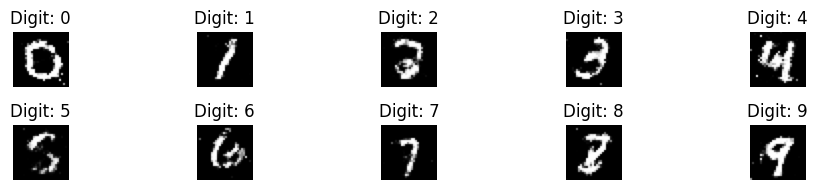

In [11]:
# @title 3. Model Training
# @markdown This cell downloads the MNIST dataset and trains the CGAN. This will take a while.

# --- Data Loading and Preprocessing (MNIST) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] for GANs
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
print(f"MNIST dataset loaded with {len(mnist_dataset)} samples.")

# --- Initialize Models, Loss, and Optimizers ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(CONFIG["latent_dim"], CONFIG["num_classes"], CONFIG["img_size"], CONFIG["channels"]).to(device)
discriminator = Discriminator(CONFIG["num_classes"], CONFIG["img_size"], CONFIG["channels"]).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=CONFIG["lr"], betas=(CONFIG["beta1"], 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=CONFIG["lr"], betas=(CONFIG["beta1"], 0.999))

print("Models, loss function, and optimizers initialized.")
print(f"Training for {CONFIG['epochs']} epochs...")

# --- Training Loop ---
for epoch in range(CONFIG["epochs"]):
    for i, (imgs, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")):
        # Adversarial ground truths
        real_labels_tensor = torch.full((imgs.size(0), 1), 1.0, device=device)
        fake_labels_tensor = torch.full((imgs.size(0), 1), 0.0, device=device)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        output_real = discriminator(real_imgs, labels)
        d_loss_real = adversarial_loss(output_real, real_labels_tensor)

        # Fake images
        z = torch.randn(imgs.size(0), CONFIG["latent_dim"], device=device)
        # Generate random labels for fake images for discriminator's training diversity
        gen_labels_d = torch.randint(0, CONFIG["num_classes"], (imgs.size(0),), device=device)
        fake_imgs = generator(z, gen_labels_d)

        output_fake = discriminator(fake_imgs.detach(), gen_labels_d) # Detach to prevent G from learning
        d_loss_fake = adversarial_loss(output_fake, fake_labels_tensor)

        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate fake images with new random noise and labels for the generator's objective
        z = torch.randn(imgs.size(0), CONFIG["latent_dim"], device=device)
        gen_labels_g = torch.randint(0, CONFIG["num_classes"], (imgs.size(0),), device=device)
        generated_imgs = generator(z, gen_labels_g)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_imgs, gen_labels_g), real_labels_tensor) # G wants D to think fakes are real

        g_loss.backward()
        optimizer_G.step()

        # --- Logging ---
        if (i+1) % 100 == 0:
            print(f"  Batch {i+1}/{len(dataloader)} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

    print(f"Epoch {epoch+1} completed. D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")

    # --- Save models periodically (optional, but good practice) ---
    if (epoch + 1) % 50 == 0 or epoch == CONFIG["epochs"] - 1:
        torch.save(generator.state_dict(), os.path.join(CONFIG["save_model_dir_drive"], f'generator_mnist_cgan_epoch_{epoch+1}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(CONFIG["save_model_dir_drive"], f'discriminator_mnist_cgan_epoch_{epoch+1}.pth'))
        print(f"Models saved after epoch {epoch+1} to Google Drive.")

# --- Final Save ---
torch.save(generator.state_dict(), generator_path_drive)
print(f"Final generator model saved to: {generator_path_drive}")

print("\nTraining complete!")

# --- Quick Test / Visualization of generated digits (optional) ---
print("\nGenerating sample digits for quick visualization:")
generator.eval() # Set generator to evaluation mode
with torch.no_grad():
    fixed_noise = torch.randn(CONFIG["num_classes"], CONFIG["latent_dim"], device=device)
    fixed_labels = torch.arange(0, CONFIG["num_classes"], device=device) # Labels 0-9

    generated_samples = generator(fixed_noise, fixed_labels).cpu().numpy()
    generated_samples = (generated_samples * 0.5) + 0.5 # Denormalize to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(CONFIG["num_classes"]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_samples[i, 0], cmap='gray')
        plt.title(f"Digit: {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
# @title 4. Streamlit App Definition and Execution
# @markdown This cell writes the Streamlit app code to a file and then runs it using ngrok for public access.
# @markdown **Keep this Colab tab open to keep the Streamlit app running and accessible.**

# Function to load the trained generator model for Streamlit (used by Colab notebook itself)
def load_generator_model(model_path, latent_dim, num_classes, img_size, channels, device):
    # Generator class is defined globally in Cell 2, so it's accessible here.
    generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval() # Set to evaluation mode
    return generator

# --- Define the Generator class for the Streamlit app's internal file ---
# This entire string will be written into 'streamlit_app.py'.
# It must include all necessary imports (torch, torch.nn) for the class.
generator_class_definition_for_streamlit = """
import torch
import torch.nn as nn # Explicitly import nn for Generator class

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.channels = channels

        self.label_emb = nn.Embedding(num_classes, num_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + num_classes, 128),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, self.img_size * self.img_size * self.channels),
            nn.Tanh() # Output pixels in [-1, 1] range
        )

    def forward(self, noise, labels):
        # Concatenate noise vector with one-hot encoded labels
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.channels, self.img_size, self.img_size)
        return img
"""

# --- Define static markdown content strings to avoid f-string parsing issues ---
welcome_markdown = """
Welcome! Use this app to generate images of handwritten digits ((0-9)) using a trained Generative Adversarial Network (GAN).
Select a digit from the sidebar and click "Generate Images" to see 5 unique examples.
"""

model_details_markdown = """
**Model Details:**
- **Framework:** PyTorch
- **Architecture:** Conditional Generative Adversarial Network (CGAN)
- **Dataset:** MNIST (**28x28** grayscale)
- **Training Environment:** Google Colab (with T4 GPU)
"""

# --- Write the entire Streamlit App to a file (streamlit_app.py) ---
# This is an f-string, but it carefully handles embedding other strings and variables.
streamlit_app_code = f"""
import streamlit as st
import numpy as np
from PIL import Image
import os
import sys

# Embed the Generator class definition directly into the Streamlit app string
{generator_class_definition_for_streamlit}

# --- Configuration from Colab Global CONFIG ---
LATENT_DIM = {CONFIG["latent_dim"]}
NUM_CLASSES = {CONFIG["num_classes"]}
IMG_SIZE = {CONFIG["img_size"]}
CHANNELS = {CONFIG["channels"]}
# The model path is now the one saved to Google Drive (passed from Colab's global scope)
MODEL_PATH = "{generator_path_drive}"

# Use GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load the trained Generator Model ---
@st.cache_resource # Cache the model to avoid reloading on every rerun of the Streamlit app
def get_generator():
    if not os.path.exists(MODEL_PATH):
        st.error(f"Model file not found at: {{MODEL_PATH}}")
        st.info("Please ensure the model was successfully trained and saved to Google Drive.")
        return None
    try:
        # Now Generator is defined within the same scope as this function call in streamlit_app.py
        generator = Generator(LATENT_DIM, NUM_CLASSES, IMG_SIZE, CHANNELS).to(DEVICE)
        generator.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        generator.eval() # Set to evaluation mode
        st.success("Model loaded successfully!")
        return generator
    except Exception as e:
        st.error(f"Error loading model: {{e}}")
        st.info("Ensure the Generator class definition matches the trained model's architecture.")
        return None

generator = get_generator()

# --- Streamlit UI ---
st.set_page_config(
    page_title="MNIST Digit Generator",
    page_icon="✍️",
    layout="centered"
)

st.title("✍️ MNIST Handwritten Digit Generator")
st.markdown("""
""" + welcome_markdown + """
""")

# Sidebar for user input
st.sidebar.header("Settings")
# Note: "(0-9)" is escaped to "((0-9))" to prevent f-string misinterpretation if st.slider processes labels as f-strings
selected_digit = st.sidebar.slider("Select a digit ((0-9)):", 0, 9, 0)
num_images_to_generate = 5 # Fixed as per requirement

if generator is None:
    st.warning("Cannot generate images because the model could not be loaded. Please check the model path and file.")
else:
    if st.sidebar.button("Generate Images"):
        st.subheader(f"Generated Images for Digit {{selected_digit}}:") # f-string for display text
        st.write("---")

        with st.spinner(f"Generating {{num_images_to_generate}} images for digit {{selected_digit}}..."):
            try:
                # Generate images
                generated_images = []
                for _ in range(num_images_to_generate):
                    # Generate random noise for diversity
                    noise = torch.randn(1, LATENT_DIM, device=DEVICE)
                    # Create a tensor for the selected digit label
                    labels = torch.tensor([selected_digit], dtype=torch.long, device=DEVICE)

                    # Generate the image
                    with torch.no_grad():
                        img = generator(noise, labels).cpu().numpy()

                    # Denormalize from [-1, 1] to [0, 1] for display
                    img = (img * 0.5) + 0.5
                    img = img.squeeze() # Remove channel dimension if it's 1 (e.g., (1, 28, 28) -> (28, 28))
                    img = (img * 255).astype(np.uint8) # Scale to 0-255 and convert to uint8 for PIL
                    generated_images.append(Image.fromarray(img))

                # Display images in a grid format (similar to MNIST examples)
                cols = st.columns(num_images_to_generate)
                for i, img_pil in enumerate(generated_images):
                    with cols[i]:
                        st.image(img_pil, caption=f"Digit {{selected_digit}} - Image {{i+1}}", use_column_width=True)
                st.success("Images generated!")

            except Exception as e:
                st.error(f"An error occurred during image generation: {{e}}")
                st.info("This might happen if the model weights are corrupted or if there's a mismatch in model architecture.")

st.markdown("---")
st.markdown(f"""
""" + model_details_markdown + """
""")
"""

# --- Write the generated Streamlit app code to a file ---
with open("streamlit_app.py", "w") as f:
    f.write(streamlit_app_code)

print("Streamlit app code written to streamlit_app.py")

# --- Run Streamlit app with ngrok ---
print("\nStarting Streamlit app and creating public tunnel via ngrok...")

from pyngrok import ngrok
from pyngrok import conf

# Set your ngrok authtoken
# You must have signed up for a free account at https://dashboard.ngrok.com/signup
# and obtained your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
# This command authenticates the ngrok client in the Colab environment.
!ngrok authtoken 2wuk8ge0RqZ0OzewPe5dnNrjWxi_4mQMB6sCivkLLuc1EuBn7 # Your authtoken goes here!

# Terminate existing ngrok tunnels if any (important for fresh starts)
ngrok.kill()

# Start ngrok tunnel for Streamlit's default port (8501)
# Streamlit will run on port 8501 inside Colab, and ngrok will expose it.
public_url = ngrok.connect(8501)
print(f"Your Streamlit app is publicly accessible at: {public_url}")
print("!!! IMPORTANT: Keep this Colab tab open for the app to remain accessible. !!!")
print("!!! The tunnel will close if the Colab runtime disconnects or times out.  !!!")

# Run Streamlit in the background
# The '&>/dev/null&' redirects output to null and runs it as a background process.
!streamlit run streamlit_app.py &>/dev/null&

# Display a clickable link to the app (for convenience in Colab output)
import IPython.display
IPython.display.display(IPython.display.HTML(f'<p><a href="{public_url}" target="_blank">Click here to open the Streamlit app</a></p>'))

print("\nStreamlit app is running!")

Streamlit app code written to streamlit_app.py

Starting Streamlit app and creating public tunnel via ngrok...
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Your Streamlit app is publicly accessible at: NgrokTunnel: "https://2142-34-125-147-104.ngrok-free.app" -> "http://localhost:8501"
!!! IMPORTANT: Keep this Colab tab open for the app to remain accessible. !!!
!!! The tunnel will close if the Colab runtime disconnects or times out.  !!!



Streamlit app is running!
